# Практика 5 - Расчет выходной мощности панели

In [59]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

In [60]:
help(pvlib.irradiance)

Help on module pvlib.irradiance in pvlib:

NAME
    pvlib.irradiance

DESCRIPTION
    The ``irradiance`` module contains functions for modeling global
    horizontal irradiance, direct normal irradiance, diffuse horizontal
    irradiance, and total irradiance under various conditions.

FUNCTIONS
    aoi(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth)
        Calculates the angle of incidence of the solar vector on a surface.
        This is the angle between the solar vector and the surface normal.
        
        Input all angles in degrees.
        
        Parameters
        ----------
        surface_tilt : numeric
            Panel tilt from horizontal.
        surface_azimuth : numeric
            Panel azimuth from north.
        solar_zenith : numeric
            Solar zenith angle.
        solar_azimuth : numeric
            Solar azimuth angle.
        
        Returns
        -------
        aoi : numeric
            Angle of incidence in degrees.
    
    aoi_p

In [61]:
import os
import inspect

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

import pvlib

### 1) Загрузка TMY-файла

In [62]:
# абсолютный путь к папке с пакетом pvlib
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# путь к файлу
datapath = os.path.join(pvlib_abspath, 'data', '703165TY.csv')
print(datapath)
# чтение файла и приведение к одному году
tmy_data, meta = pvlib.iotools.read_tmy3(datapath, coerce_year=2015)
tmy_data.index.name = 'Time'

# TMY-файл включает почасовые данные
# сместим ряд на 30 минут для расчета позиции солнца
tmy_data = tmy_data.shift(freq='-30Min')['2015']

C:\Users\Nepsh\AppData\Roaming\Python\Python39\site-packages\pvlib\data\703165TY.csv


C:\Users\Nepsh\AppData\Local\Temp\ipykernel_19444\4035999919.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [63]:
tmy_data.head()

,Date (MM/DD/YYYY),Time (HH:MM),ETR,ETRN,GHI,GHISource,GHIUncertainty,DNI,DNISource,DNIUncertainty,...,AOD,AODSource,AODUncertainty,Alb,AlbSource,AlbUncertainty,Lprecipdepth,Lprecipquantity,LprecipSource,LprecipUncertainty
Time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:30:00-09:00,01/01/1997,01:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 01:30:00-09:00,01/01/1997,02:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 02:30:00-09:00,01/01/1997,03:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 03:30:00-09:00,01/01/1997,04:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 04:30:00-09:00,01/01/1997,05:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0


In [64]:
tmy_data.keys()

Index(['Date (MM/DD/YYYY)', 'Time (HH:MM)', 'ETR', 'ETRN', 'GHI', 'GHISource',
       'GHIUncertainty', 'DNI', 'DNISource', 'DNIUncertainty', 'DHI',
       'DHISource', 'DHIUncertainty', 'GHillum', 'GHillumSource',
       'GHillumUncertainty', 'DNillum', 'DNillumSource', 'DNillumUncertainty',
       'DHillum', 'DHillumSource', 'DHillumUncertainty', 'Zenithlum',
       'ZenithlumSource', 'ZenithlumUncertainty', 'TotCld', 'TotCldSource',
       'TotCldUncertainty', 'OpqCld', 'OpqCldSource', 'OpqCldUncertainty',
       'DryBulb', 'DryBulbSource', 'DryBulbUncertainty', 'DewPoint',
       'DewPointSource', 'DewPointUncertainty', 'RHum', 'RHumSource',
       'RHumUncertainty', 'Pressure', 'PressureSource', 'PressureUncertainty',
       'Wdir', 'WdirSource', 'WdirUncertainty', 'Wspd', 'WspdSource',
       'WspdUncertainty', 'Hvis', 'HvisSource', 'HvisUncertainty', 'CeilHgt',
       'CeilHgtSource', 'CeilHgtUncertainty', 'Pwat', 'PwatSource',
       'PwatUncertainty', 'AOD', 'AODSource', 'AODU

In [91]:
pvlib.iotools.read_tmy3?

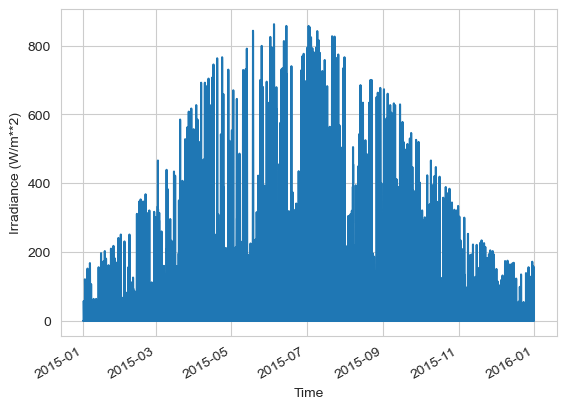

In [65]:
tmy_data['GHI'].plot()
plt.ylabel('Irradiance (W/m**2)');

In [8]:
meta

{'USAF': 703165,
 'Name': '"SAND POINT"',
 'State': 'AK',
 'TZ': -9.0,
 'latitude': 55.317,
 'longitude': -160.517,
 'altitude': 7.0}

In [66]:
#Подсветим точку на карте
import plotly.express as px
data_geo={'Latitude':[meta['latitude']],
          'Longitude': [meta['longitude']]}
# выведем карту с помощью plotly
fig = px.scatter_geo(data_geo, lat = 'Latitude', lon = 'Longitude',
                     hover_data=['Latitude', 'Longitude'],
                     projection="natural earth")

# установим название для карты
fig.update_layout(title = meta['Name']+' coordinates', title_x = 0.5)
# отобразим карту
fig.show()

### 2) Расчет параметров для модели

Для расчета генерируемой мощности необходимо определить:
- положение солнца
- внеземное излучение
- airmass
- угол падения
- POA рассеянное излучение неба и земли
- температуры ячеек и модулей

In [67]:
surface_tilt = 30
surface_azimuth = 180 #  0=North, 90=East, 180=South, 270=West
albedo = 0.2

# сформируем объект, включающий данные о местоположении
sand_point = pvlib.location.Location(meta['latitude'], meta['longitude'], tz='US/Alaska',
                                     altitude=meta['altitude'], name=meta['Name'].replace('"',''))
print(sand_point)

Location: 
  name: SAND POINT
  latitude: 55.317
  longitude: -160.517
  altitude: 7.0
  tz: US/Alaska


#### 2.1) Расчет положения солнца для рассматриваемого периода


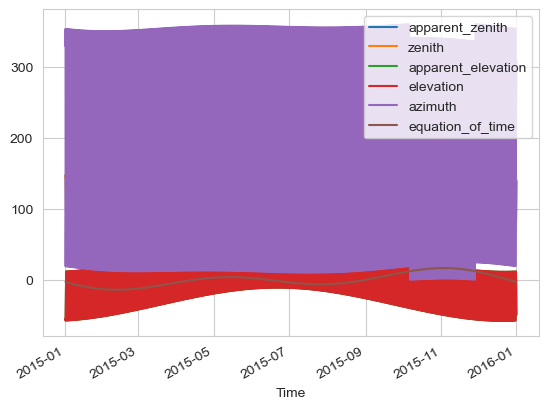

In [68]:
solpos = pvlib.solarposition.get_solarposition(tmy_data.index, sand_point.latitude, sand_point.longitude)

solpos.plot();

#### 2.2) Расчет внеземной радиации

Расчет внеземной радиации. Необходим для многочисленных моделей расчета рассеяной солнечной радиации.

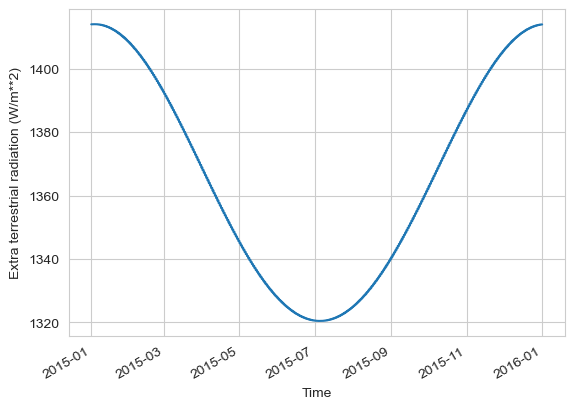

In [69]:
dni_extra = pvlib.irradiance.get_extra_radiation(tmy_data.index)
dni_extra = pd.Series(dni_extra, index=tmy_data.index)

dni_extra.plot()
plt.ylabel('Extra terrestrial radiation (W/m**2)');

In [70]:
type(dni_extra)

pandas.core.series.Series

#### 2.3) Расчет Airmass

Расчет airmass.

In [16]:
pvlib.atmosphere.get_relative_airmass?

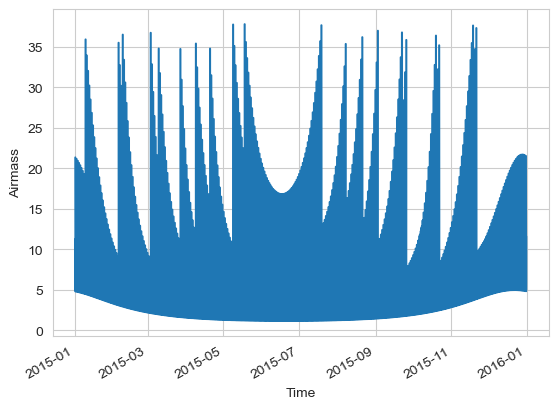

In [71]:
airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])

airmass.plot()
plt.ylabel('Airmass');

In [73]:
import plotly.graph_objs as go
# Создадим фигуру plotly
fig = go.Figure()

# Добавим визуализацию трех колонок
fig.add_trace(go.Scatter(x=airmass.index, y=airmass, name="airmass"))
# Задать параметры плота
fig.update_layout(title="Airmass", xaxis_title="Date", yaxis_title="p.u.")
# Отобразить полотно
fig.show()

In [74]:
airmass.isna().sum()

4305

Датасет не включает данные для ночных часов, поэтому в нем есть NaN

#### 2.4) Расчет диффузной солнечной радиации (POA sky diffuse)

Используем модель Hay Davies для расчета plane of array diffuse sky radiation (POA диффузная радиация).

In [75]:
pvlib.irradiance.haydavies?

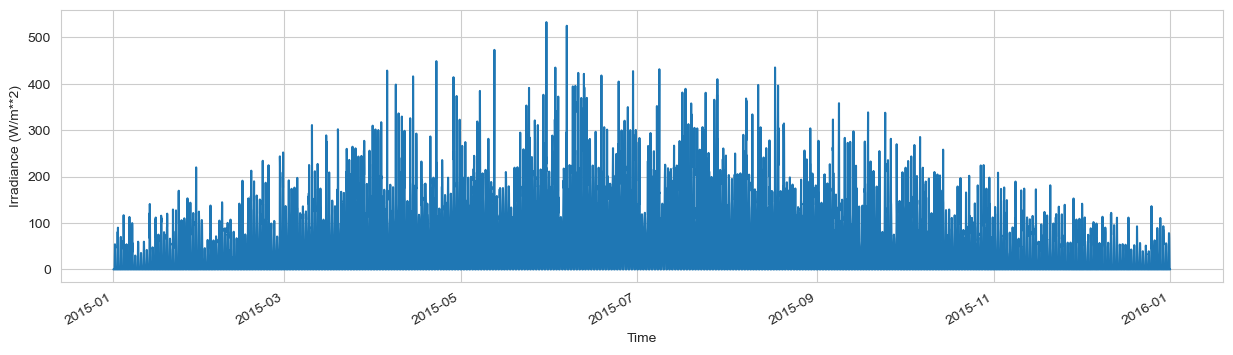

In [76]:
poa_sky_diffuse = pvlib.irradiance.haydavies(surface_tilt, surface_azimuth,
                                             tmy_data['DHI'], tmy_data['DNI'], dni_extra,
                                             solpos['apparent_zenith'], solpos['azimuth'])

poa_sky_diffuse.plot(figsize=(15,4))
plt.ylabel('Irradiance (W/m**2)');

#### 2.5) Расчет POA ground diffuse

Расчитаем отраженную от поверхности земли солнечную радиацию. Также можно задать параметр ``surface_type``.

In [77]:
pvlib.irradiance.get_ground_diffuse?

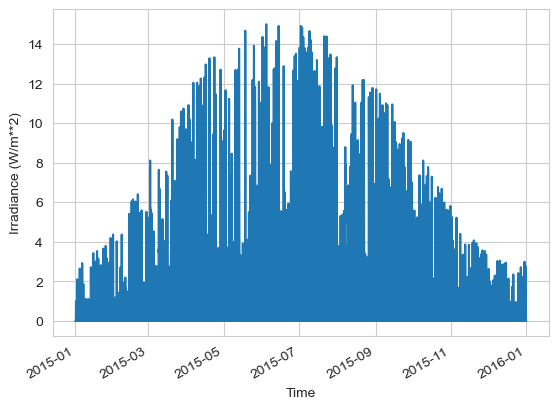

In [78]:
poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(surface_tilt,
                                                         tmy_data['GHI'],
                                                         #albedo=albedo,
                                                         surface_type="fresh grass")

poa_ground_diffuse.plot()
plt.ylabel('Irradiance (W/m**2)');

#### 2.6) Расчет AOI

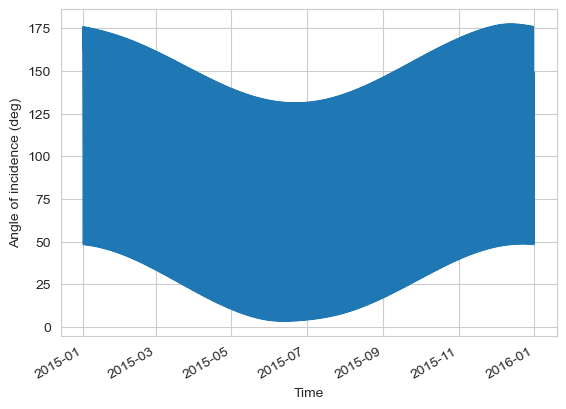

In [79]:
aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])

aoi.plot()
plt.ylabel('Angle of incidence (deg)');

#### 2.7) Расчет POA total

In [80]:
pvlib.irradiance.poa_components?

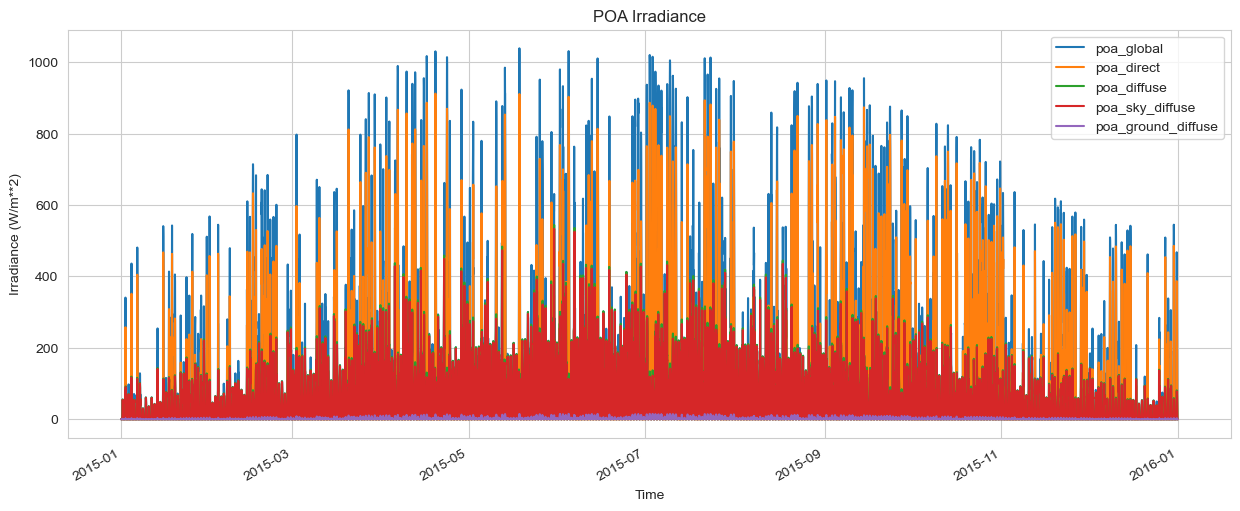

In [81]:
poa_irrad = pvlib.irradiance.poa_components(aoi, tmy_data['DNI'], poa_sky_diffuse, poa_ground_diffuse)

poa_irrad.plot(figsize=(15,6))
plt.ylabel('Irradiance (W/m**2)')
plt.title('POA Irradiance');

#### 2.8) Расчет температуры ячеек

In [82]:
pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS?

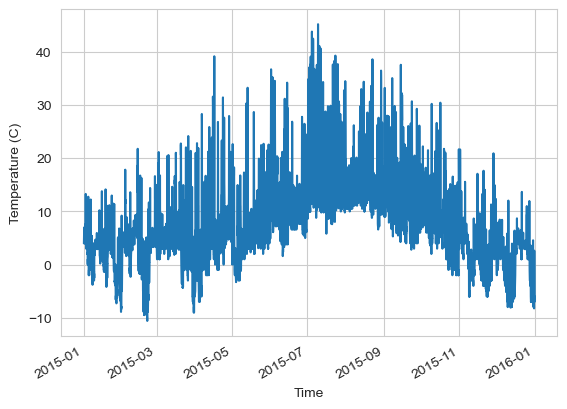

In [83]:
thermal_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
pvtemps = pvlib.temperature.sapm_cell(poa_irrad['poa_global'], tmy_data['DryBulb'], tmy_data['Wspd'], **thermal_params)

pvtemps.plot()
plt.ylabel('Temperature (C)');

## 3) Расчет DC power с использованием модели SAPM

Больше информации о SAPM можно найти по [ссылке](https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/point-value-models/sandia-pv-array-performance-model/)

In [85]:
pvlib.pvsystem.retrieve_sam?

In [86]:
sandia_modules = pvlib.pvsystem.retrieve_sam(name='SandiaMod')

Выберем один из модулей

In [87]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                           -0.01284
Bvoco                                                        -0.21696
Mbvoc               

Расчет эффективной солнечной радиации

In [89]:
pvlib.pvsystem.sapm_effective_irradiance?

In [90]:
effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(poa_irrad.poa_direct, poa_irrad.poa_diffuse, airmass, aoi, sandia_module)

Используем метод SAPM с использованием параметров рассчитанных выше

In [91]:
pvlib.pvsystem.sapm?

In [92]:
sapm_out = pvlib.pvsystem.sapm(effective_irradiance, pvtemps, sandia_module)
sapm_out.head(30)

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
Time,,,,,,,
2015-01-01 00:30:00-09:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-01 01:30:00-09:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-01 02:30:00-09:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-01 03:30:00-09:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-01 04:30:00-09:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-01 05:30:00-09:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-01 06:30:00-09:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-01 07:30:00-09:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-01 08:30:00-09:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


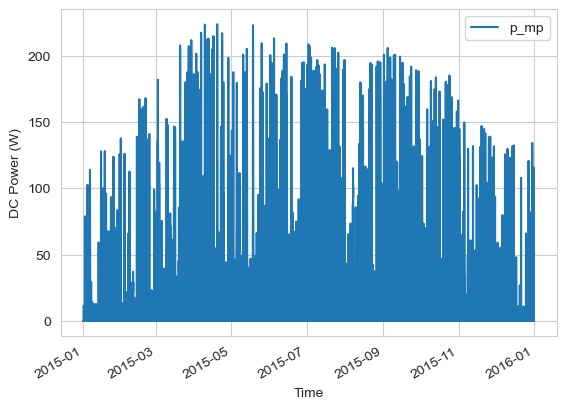

In [93]:
sapm_out[['p_mp']].plot()
plt.ylabel('DC Power (W)');

In [94]:
sapm_out[['p_mp']].resample('Y').sum()

,p_mp
Time,
2015-12-31 00:00:00-09:00,217813.933977


## 4) Расчет DC power используя модель single diode

In [95]:
cec_modules = pvlib.pvsystem.retrieve_sam(name='CECMod')
cec_module = cec_modules.Canadian_Solar_Inc__CS5P_220M

In [96]:
d = {k: cec_module[k] for k in ['a_ref', 'I_L_ref', 'I_o_ref', 'R_sh_ref', 'R_s']}

In [97]:
d

{'a_ref': 2.635926,
 'I_L_ref': 5.11426,
 'I_o_ref': 8.102508e-10,
 'R_sh_ref': 381.254425,
 'R_s': 1.066023}

In [98]:
pvlib.pvsystem.calcparams_desoto?

In [99]:
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = (
    pvlib.pvsystem.calcparams_desoto(poa_irrad.poa_global,
                                     pvtemps,
                                     cec_module['alpha_sc'],
                                     EgRef=1.121,
                                     dEgdT=-0.0002677, **d))

In [100]:
single_diode_out = pvlib.pvsystem.singlediode(photocurrent, saturation_current,
                                              resistance_series, resistance_shunt, nNsVth)

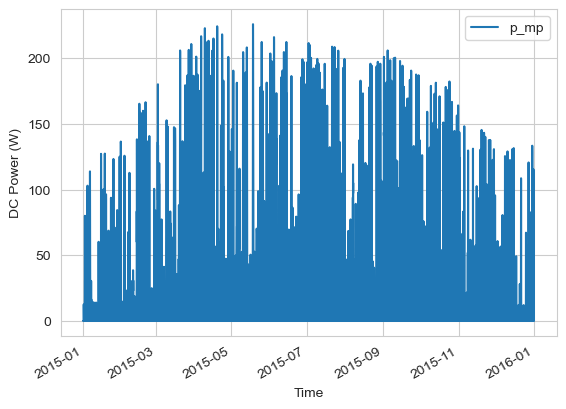

In [101]:
single_diode_out[['p_mp']].plot()
plt.ylabel('DC Power (W)');

In [102]:
single_diode_out[['p_mp']].resample('Y').sum()

,p_mp
Time,
2015-12-31 00:00:00-09:00,228691.893608


## 5) Расчет AC power using SAPM

Извлечение данных по инверторам

In [103]:
pvlib.pvsystem.retrieve_sam?

In [43]:
sapm_inverters = pvlib.pvsystem.retrieve_sam('sandiainverter')

In [104]:
sapm_inverters

,ABB__MICRO_0_25_I_OUTD_US_208__208V_,ABB__MICRO_0_25_I_OUTD_US_240__240V_,ABB__MICRO_0_3_I_OUTD_US_208__208V_,ABB__MICRO_0_3_I_OUTD_US_240__240V_,ABB__MICRO_0_3HV_I_OUTD_US_208__208V_,ABB__MICRO_0_3HV_I_OUTD_US_240__240V_,ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_,ABB__PVI_10_0_I_OUTD_x_US_480_y_z__480V_,ABB__PVI_12_0_I_OUTD_x_US_480_y__480V_,ABB__PVI_3_0_OUTD_S_US__208V_,...,Zigor__Sunzet_3_TL_US__240V_,i_Energy__GT260__240V_,iPower__SHO_1_1__120V_,iPower__SHO_2_0__240V_,iPower__SHO_2_5__240V_,iPower__SHO_3_0__240V_,iPower__SHO_3_5__240V_,iPower__SHO_4_6__208V_,iPower__SHO_4_8__240V_,iPower__SHO_5_2__240V_
Vac,208,240,208,240,208,240,208,480,480,208,...,240,240,120,240,240,240,240,208,240,240
Pso,2.089607,2.240412,1.846506,1.950539,1.769444,1.843781,46.863808,67.790878,62.554672,18.166279,...,36.033405,2.530101,22.09536,24.465775,42.776474,31.682003,64.774162,54.570091,85.145699,62.486748
Paco,250.0,250.0,300.0,300.0,300.0,300.0,10000.0,10000.0,12000.0,3000.0,...,3180.0,230.0,1100.0,2000.0,2500.0,3000.0,3500.0,4600.0,4800.0,5200.0
Pdco,259.588593,259.492065,311.66925,311.580872,312.421082,312.004578,10488.306641,10295.979492,12358.804688,3142.30127,...,3315.654297,245.630447,1194.094849,2161.879639,2632.835693,3205.932617,3641.840332,4797.806641,4968.027832,5382.856934
Vdco,40.0,40.0,40.0,40.0,45.0,45.0,320.0,362.0,370.0,310.0,...,375.0,40.0,182.0,199.0,218.0,222.5,263.0,254.0,263.0,280.0
C0,-0.000041,-0.000039,-0.000033,-0.000034,-0.000045,-0.000035,-0.000003,-0.000001,-0.000001,-0.000008,...,-0.000008,0.000062,-0.000021,-0.000013,-0.000014,-0.000008,-0.000009,-0.000006,-0.000006,-0.000005
C1,-0.000091,-0.000132,-0.000192,-0.000256,-0.000196,-0.000227,-0.000036,-0.000049,-0.000056,-0.000011,...,-0.000075,-0.000098,0.000057,0.000055,0.000061,0.000036,0.000035,0.000028,0.000034,0.000044
C2,0.000494,0.002418,0.000907,0.002453,0.001959,-0.000526,0.000305,-0.00052,-0.001437,0.000999,...,0.000544,0.000231,0.002001,0.001703,0.002053,0.001708,0.001417,0.001381,0.000586,0.00126
C3,-0.013171,-0.014926,-0.031742,-0.028223,-0.023725,-0.041214,-0.002351,-0.003855,-0.007112,-0.000287,...,-0.000338,0.121032,0.000623,0.000315,0.00153,0.00086,0.001218,0.000889,0.000195,0.000367
Pnt,0.075,0.075,0.09,0.09,0.09,0.09,0.1,0.4,0.4,0.1,...,0.954,0.069,0.33,0.6,0.75,0.9,1.05,1.38,1.44,1.56


Выберем конкретный инвертор

In [105]:
sapm_inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
sapm_inverter

Vac                          208
Pso                     2.089607
Paco                       250.0
Pdco                  259.588593
Vdco                        40.0
C0                     -0.000041
C1                     -0.000091
C2                      0.000494
C3                     -0.013171
Pnt                        0.075
Vdcmax                      50.0
Idcmax                  6.489715
Mppt_low                    30.0
Mppt_high                   50.0
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__MICRO_0_25_I_OUTD_US_208__208V_, dtype: object

Параметры инвертора можно найти по [ссылке](https://www.solaris-shop.com/content/MICRO0.25IOUTDUS%20Specs.pdf)

In [71]:
pvlib.inverter.sandia?

Подробнее с используемой моделью можно ознакомиться по [ссылке](https://energy.sandia.gov/wp-content/gallery/uploads/Performance-Model-for-Grid-Connected-Photovoltaic-Inverters.pdf)

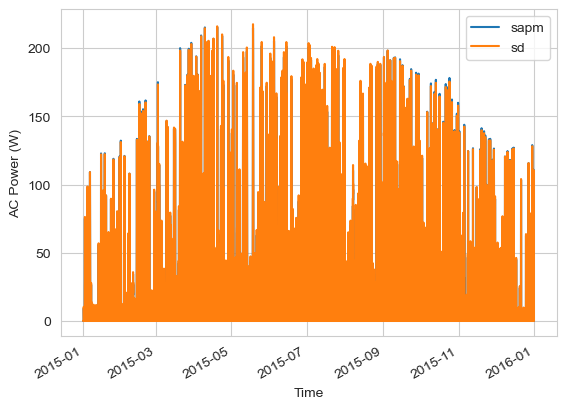

In [106]:
p_acs = pd.DataFrame()
p_acs['sapm'] = pvlib.inverter.sandia(sapm_out.v_mp, sapm_out.p_mp, sapm_inverter)
p_acs['sd'] = pvlib.inverter.sandia(single_diode_out.v_mp, single_diode_out.p_mp, sapm_inverter)

p_acs.plot()
plt.ylabel('AC Power (W)');

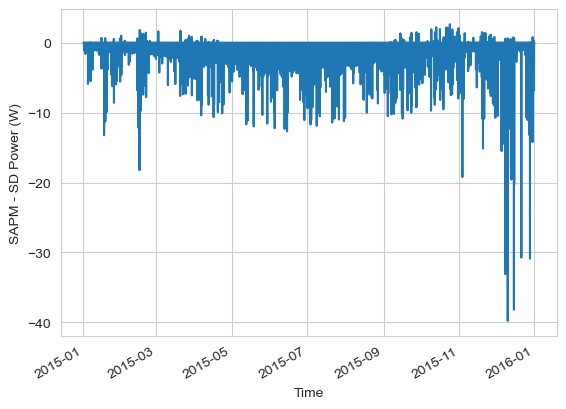

In [107]:
diff = p_acs['sapm'] - p_acs['sd']
diff.plot()
plt.ylabel('SAPM - SD Power (W)');

In [108]:
p_acs[1:24]

,sapm,sd
Time,,
2015-01-01 01:30:00-09:00,-0.075000,-0.075000
2015-01-01 02:30:00-09:00,-0.075000,-0.075000
2015-01-01 03:30:00-09:00,-0.075000,-0.075000
2015-01-01 04:30:00-09:00,-0.075000,-0.075000
2015-01-01 05:30:00-09:00,-0.075000,-0.075000
2015-01-01 06:30:00-09:00,-0.075000,-0.075000
2015-01-01 07:30:00-09:00,-0.075000,-0.075000
2015-01-01 08:30:00-09:00,-0.075000,-0.075000
2015-01-01 09:30:00-09:00,-0.075000,-0.075000


In [110]:
p_acs.resample('Y').sum()

,sapm,sd
Time,,
2015-12-31 00:00:00-09:00,204066.910998,214100.8221


Визуализируем несколько дней

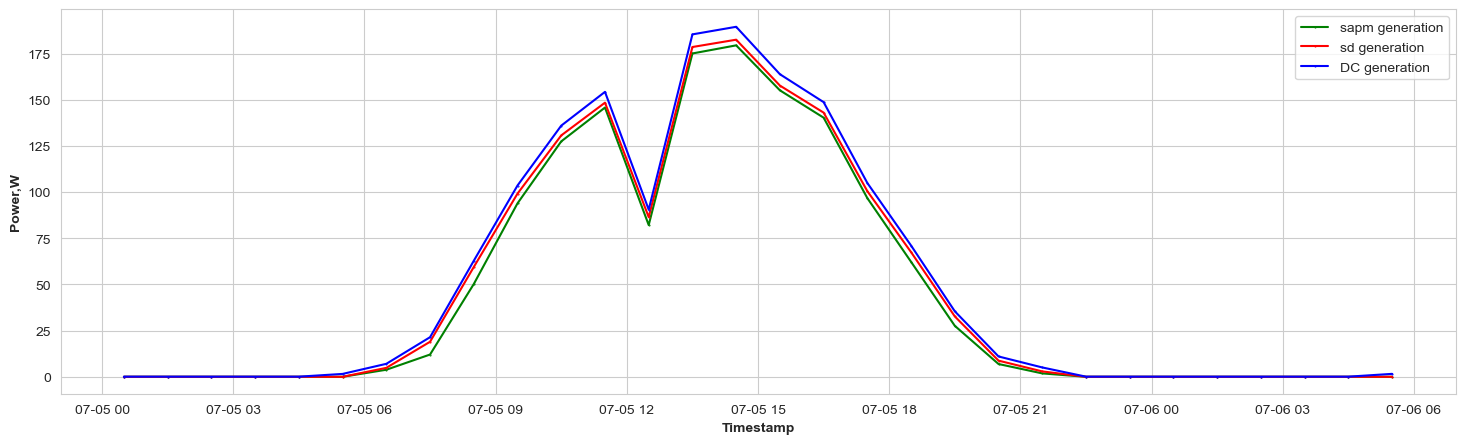

In [111]:
start, end = '2015-07-05 00:00:00', '2015-07-06 06:00:00'
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(p_acs.loc[start:end, 'sapm'],
        marker='.', linestyle='-', linewidth=1.5, markersize=1, label='sapm generation', color='green')
ax.plot(p_acs.loc[start:end, 'sd'],
        marker='.', linestyle='-', linewidth=1.5, markersize=1, label='sd generation', color='red')
ax.plot(single_diode_out.loc[start:end, 'p_mp'],
        marker='.', linestyle='-', linewidth=1.5, markersize=1, label='DC generation', color='blue')
ax.set_xlabel('Timestamp', loc='center', fontweight='bold')
ax.set_ylabel('Power,W', loc='center', fontweight='bold')
ax.legend()


Статистика по выдаче мощности на стороне AC

In [51]:
p_acs.describe()

,sapm,sd
count,8760.000000,8760.000000
mean,23.295309,24.440733
std,42.993809,43.619310
min,-0.075000,-0.075000
25%,-0.075000,-0.075000
50%,-0.075000,-0.075000
75%,27.984646,30.897592
max,215.619362,217.708025


In [52]:
p_acs.sum()

sapm    204066.910998
sd      214100.822100
dtype: float64

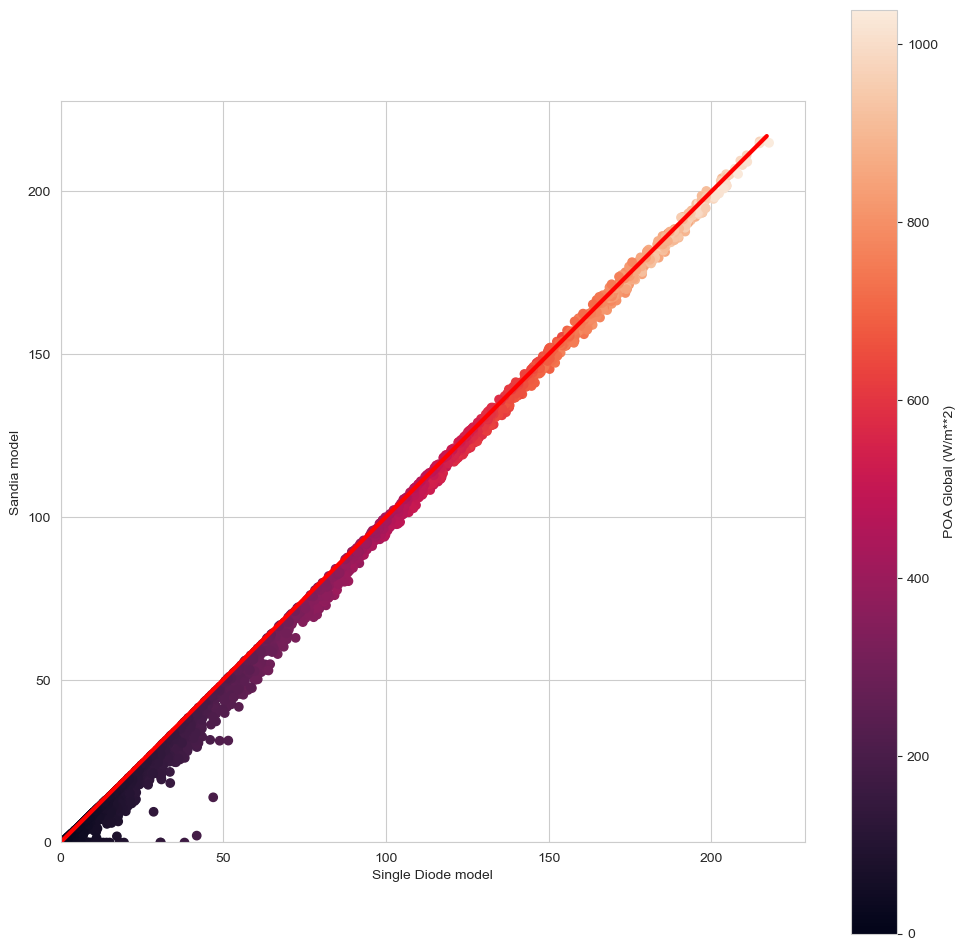

In [112]:
# create data for a y=x line
p_ac_max = p_acs.max().max()
yxline = np.arange(0, p_ac_max)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, aspect='equal')
sc = ax.scatter(p_acs['sd'], p_acs['sapm'], c=poa_irrad.poa_global, alpha=1)  
ax.plot(yxline, yxline, 'r', linewidth=3)
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel('Single Diode model')
ax.set_ylabel('Sandia model')
fig.colorbar(sc, label='POA Global (W/m**2)');

Можно изменить значение ``c`` чтобы увидеть влияние других метеопараметров на генерацию. Ниже запишем простую функцию для этой задачи

In [113]:
def sapm_sd_scatter(c_data, label=None, **kwargs):
    """Строит диграмму рассеяния SAPM p_ac vs. single diode p_ac.

    Параметры
    ----------
    c_data : array-like
        Определяет цветовое отображение на диаграмме.
        Должен иметь такую же размерность, что и фреймы с мощностью.
        
    kwargs passed to ``scatter``.
    
    Returns
    -------
    tuple of fig, ax objects
    """
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, aspect='equal')
    sc = ax.scatter(p_acs['sd'], p_acs['sapm'], c=c_data, alpha=1, **kwargs)  
    ax.plot(yxline, yxline, 'r', linewidth=3)
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel('Single diode model power (W)')
    ax.set_ylabel('Sandia model power (W)')
    fig.colorbar(sc, label='{}'.format(label), shrink=0.75)
    
    return fig, ax

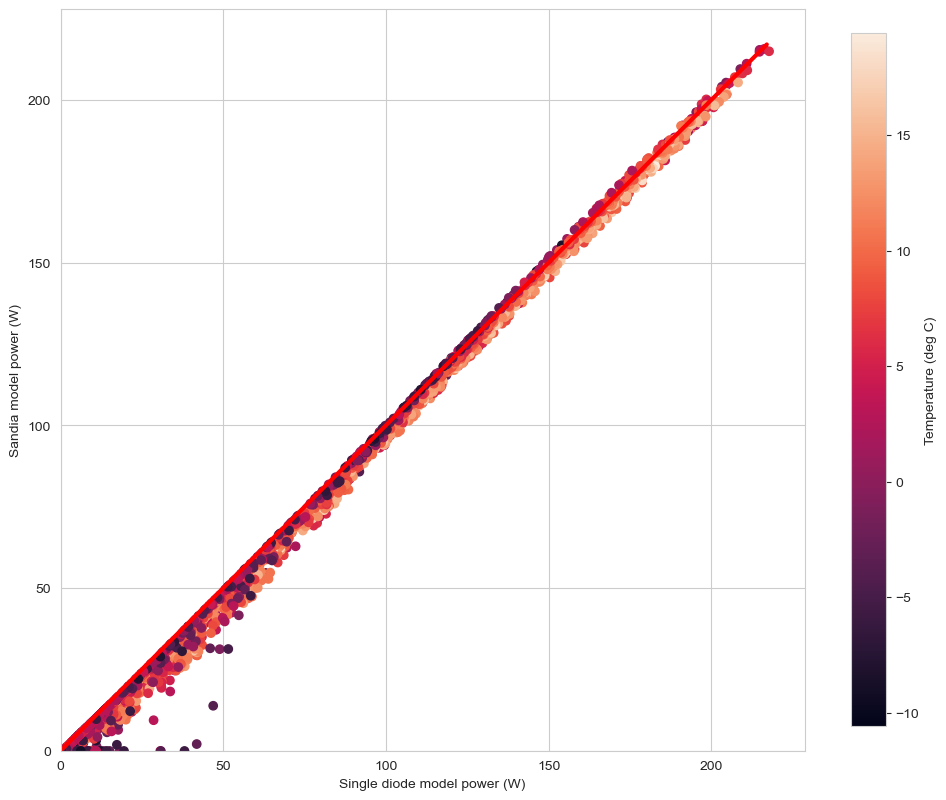

In [114]:
sapm_sd_scatter(tmy_data.DryBulb, label='Temperature (deg C)');

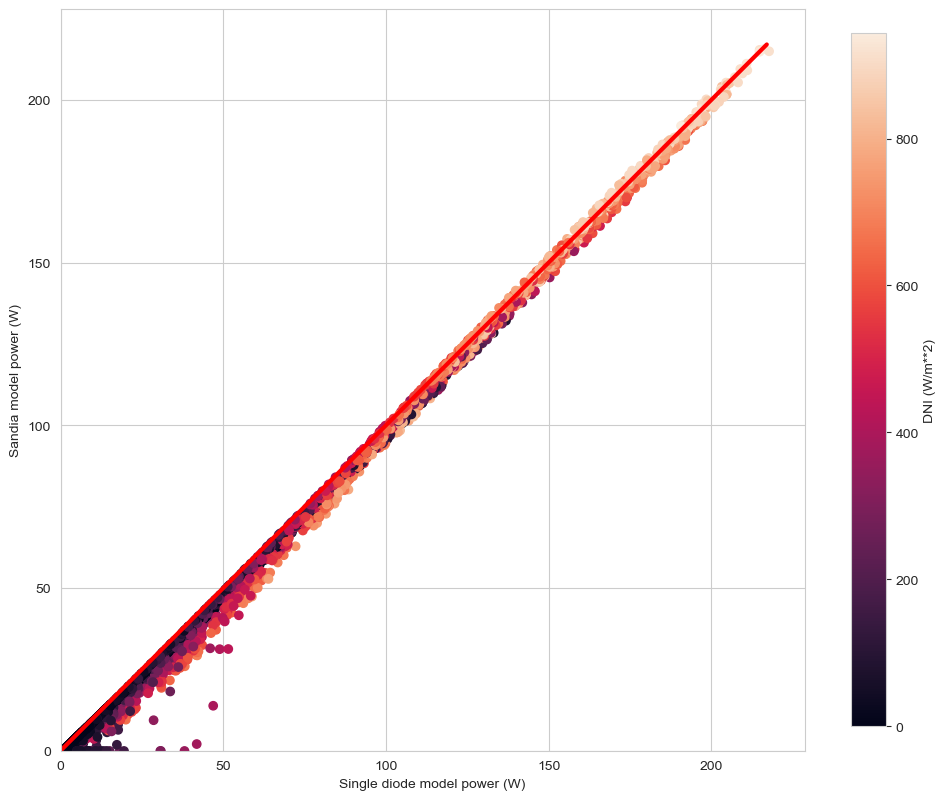

In [115]:
sapm_sd_scatter(tmy_data.DNI, label='DNI (W/m**2)');

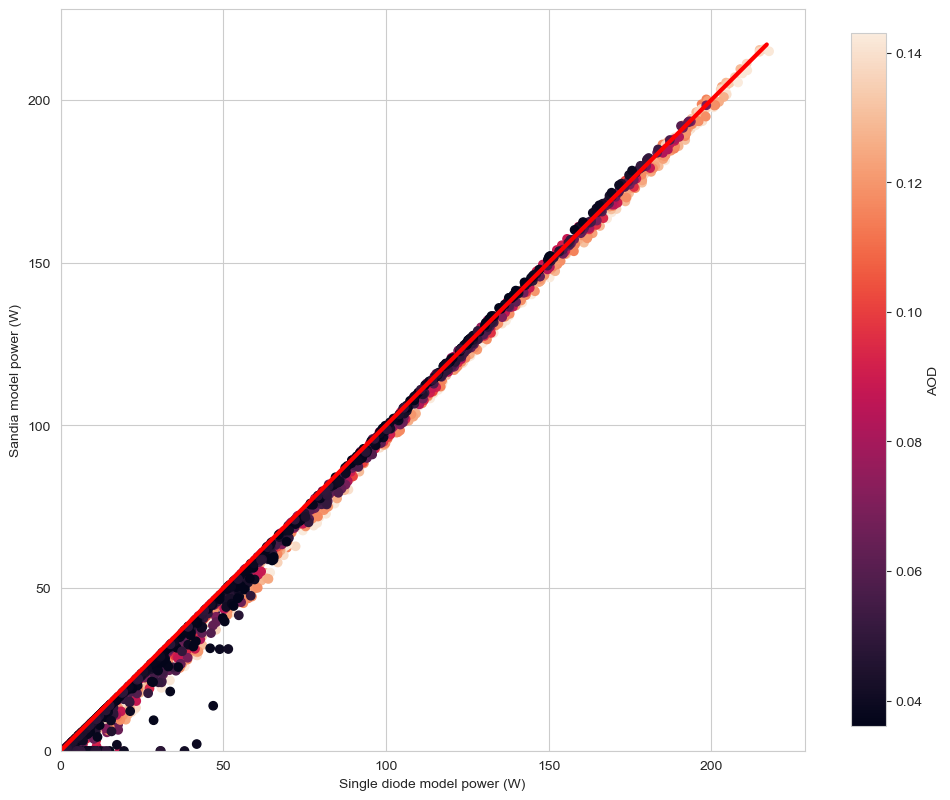

In [116]:
sapm_sd_scatter(tmy_data.AOD, label='AOD');

<AxesSubplot:xlabel='Time'>

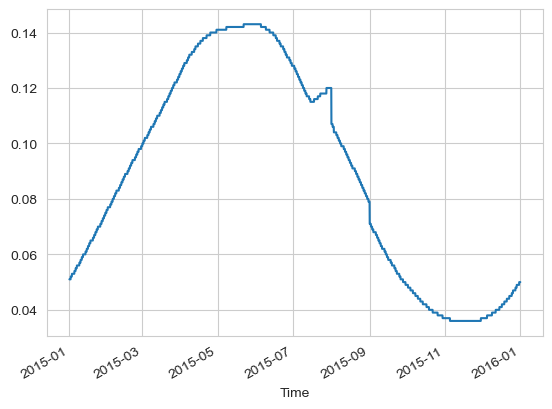

In [117]:
tmy_data.AOD.plot()

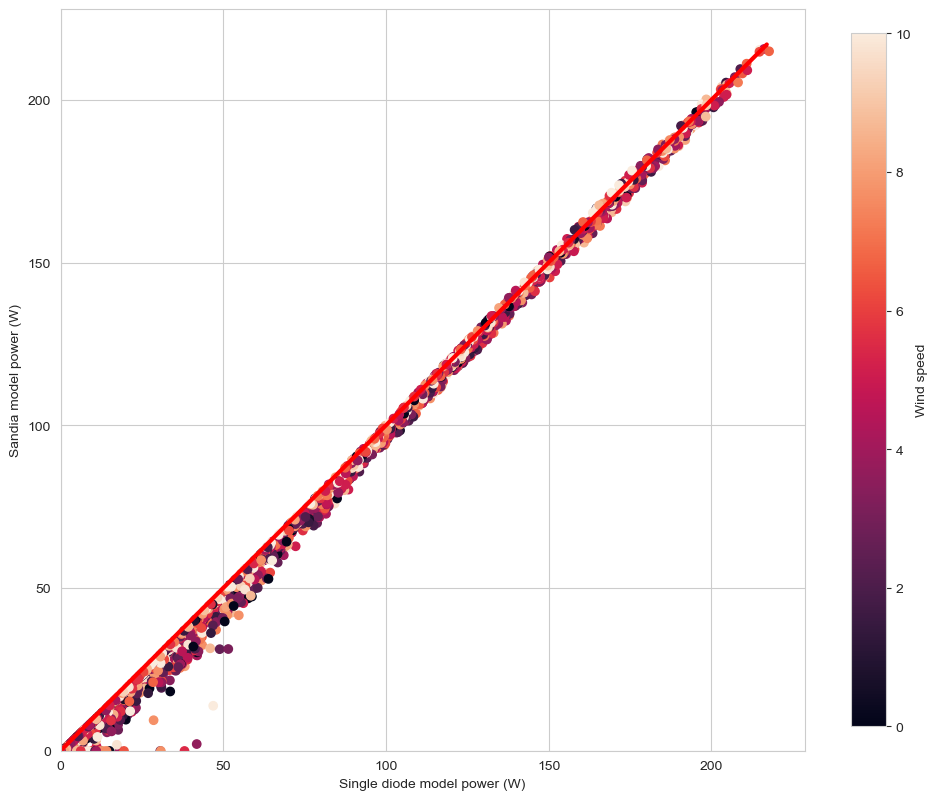

In [119]:
sapm_sd_scatter(tmy_data.Wspd, label='Wind speed', vmax=10);

Notice the use of the ``vmax`` keyword argument in the above example. The ``**kwargs`` pattern allows us to easily pass non-specified arguments to nested functions.

In [120]:
def sapm_other_scatter(c_data, x_data, clabel=None, xlabel=None, aspect_equal=False, **kwargs):
    """Display a scatter plot of SAPM p_ac vs. something else.
    
    You need to re-execute this cell if you re-run the p_ac calculation.
    
    Parameters
    ----------
    c_data : array-like
        Determines the color of each point on the scatter plot.
        Must be same length as p_acs.
    x_data : array-like
        
    kwargs passed to ``scatter``.
    
    Returns
    -------
    tuple of fig, ax objects
    """
    
    fig = plt.figure(figsize=(12,12))
    
    if aspect_equal:
        ax = fig.add_subplot(111, aspect='equal')
    else:
        ax = fig.add_subplot(111)
    sc = ax.scatter(x_data, p_acs['sapm'], c=c_data, alpha=1, cmap=mpl.cm.YlGnBu_r, **kwargs)  
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel('{}'.format(xlabel))
    ax.set_ylabel('Sandia model power (W)')
    fig.colorbar(sc, label='{}'.format(clabel), shrink=0.75)
    
    return fig, ax

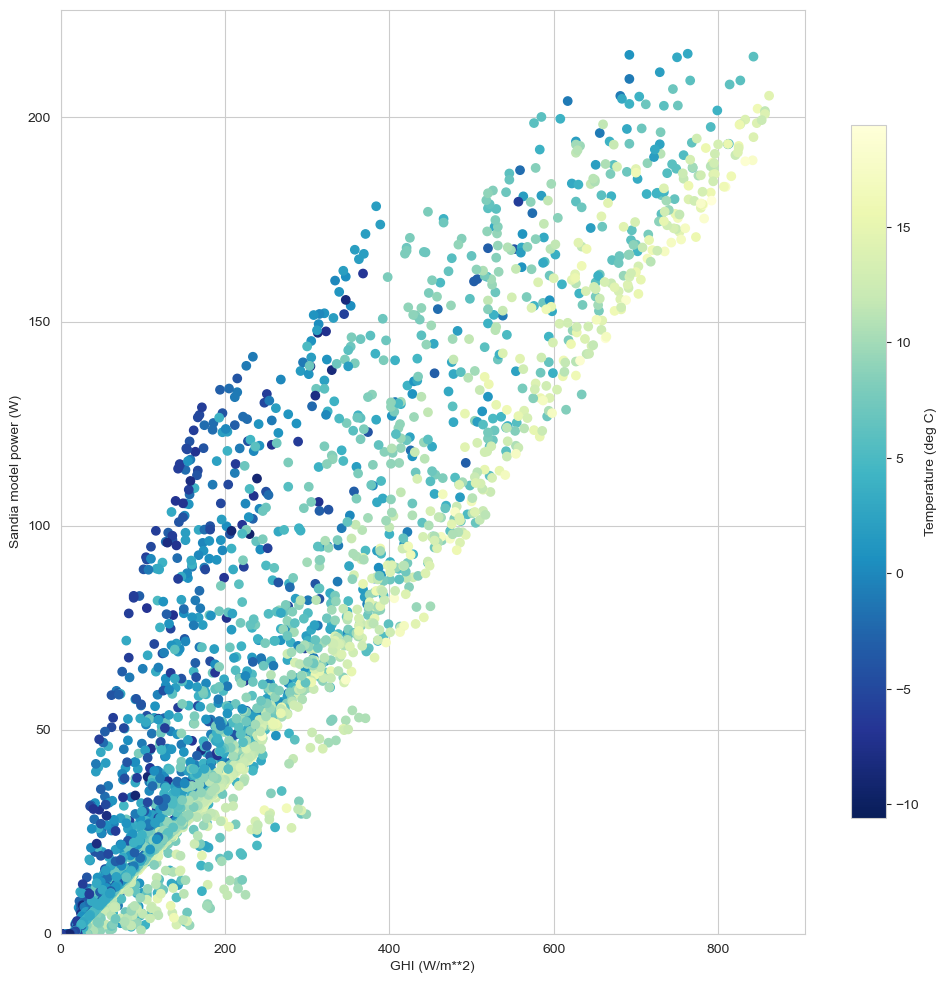

In [121]:
sapm_other_scatter(tmy_data.DryBulb, tmy_data.GHI, clabel='Temperature (deg C)', xlabel='GHI (W/m**2)');

In [98]:
p_acs

,sapm,sd
Time,,
2015-01-01 00:30:00-09:00,-0.075,-0.075
2015-01-01 01:30:00-09:00,-0.075,-0.075
2015-01-01 02:30:00-09:00,-0.075,-0.075
2015-01-01 03:30:00-09:00,-0.075,-0.075
2015-01-01 04:30:00-09:00,-0.075,-0.075
...,...,...
2015-12-31 19:30:00-09:00,-0.075,-0.075
2015-12-31 20:30:00-09:00,-0.075,-0.075
2015-12-31 21:30:00-09:00,-0.075,-0.075


In [122]:
corr_matrix_for=pd.merge(p_acs, tmy_data[['DNI', 'GHI', 'TotCld', 'DryBulb', 'Wspd', 'AOD', 'OpqCld' ]], right_index=True, left_index=True)

In [123]:
tmy_data

,Date (MM/DD/YYYY),Time (HH:MM),ETR,ETRN,GHI,GHISource,GHIUncertainty,DNI,DNISource,DNIUncertainty,...,AOD,AODSource,AODUncertainty,Alb,AlbSource,AlbUncertainty,Lprecipdepth,Lprecipquantity,LprecipSource,LprecipUncertainty
Time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:30:00-09:00,01/01/1997,01:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 01:30:00-09:00,01/01/1997,02:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 02:30:00-09:00,01/01/1997,03:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 03:30:00-09:00,01/01/1997,04:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 04:30:00-09:00,01/01/1997,05:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 19:30:00-09:00,12/31/1998,20:00,0,0,0,1,0,0,1,0,...,0.050,F,8,0.25,F,8,-9900,-9900,?,0
2015-12-31 20:30:00-09:00,12/31/1998,21:00,0,0,0,1,0,0,1,0,...,0.050,F,8,0.25,F,8,-9900,-9900,?,0
2015-12-31 21:30:00-09:00,12/31/1998,22:00,0,0,0,1,0,0,1,0,...,0.050,F,8,0.25,F,8,-9900,-9900,?,0


In [114]:
corr_matrix_for

,sapm,sd,DNI,GHI,TotCld,DryBulb,Wspd,AOD,OpqCld
Time,,,,,,,,,
2015-01-01 00:30:00-09:00,-0.075,-0.075,0,0,9,4.0,2.1,0.051,9
2015-01-01 01:30:00-09:00,-0.075,-0.075,0,0,10,4.0,0.0,0.051,10
2015-01-01 02:30:00-09:00,-0.075,-0.075,0,0,9,5.0,3.1,0.051,9
2015-01-01 03:30:00-09:00,-0.075,-0.075,0,0,10,5.0,2.1,0.051,10
2015-01-01 04:30:00-09:00,-0.075,-0.075,0,0,10,6.0,3.6,0.051,10
...,...,...,...,...,...,...,...,...,...
2015-12-31 19:30:00-09:00,-0.075,-0.075,0,0,10,-7.0,5.7,0.050,9
2015-12-31 20:30:00-09:00,-0.075,-0.075,0,0,6,-7.0,5.1,0.050,3
2015-12-31 21:30:00-09:00,-0.075,-0.075,0,0,10,-6.0,2.6,0.050,10


In [124]:
corr_matrix = corr_matrix_for.corr()
print(corr_matrix)

             sapm        sd       DNI       GHI    TotCld   DryBulb      Wspd  \
sapm     1.000000  0.999035  0.870530  0.950215 -0.330087  0.223874  0.074149   
sd       0.999035  1.000000  0.874570  0.955425 -0.331787  0.230002  0.073021   
DNI      0.870530  0.874570  1.000000  0.789422 -0.534908  0.159653  0.033862   
GHI      0.950215  0.955425  0.789422  1.000000 -0.254842  0.341153  0.044360   
TotCld  -0.330087 -0.331787 -0.534908 -0.254842  1.000000  0.128505  0.010964   
DryBulb  0.223874  0.230002  0.159653  0.341153  0.128505  1.000000 -0.283466   
Wspd     0.074149  0.073021  0.033862  0.044360  0.010964 -0.283466  1.000000   
AOD      0.147077  0.153355  0.051967  0.265702  0.100521  0.259106 -0.173018   
OpqCld  -0.343615 -0.345326 -0.547482 -0.264962  0.957867  0.142356 -0.015814   

              AOD    OpqCld  
sapm     0.147077 -0.343615  
sd       0.153355 -0.345326  
DNI      0.051967 -0.547482  
GHI      0.265702 -0.264962  
TotCld   0.100521  0.957867  
DryBulb  

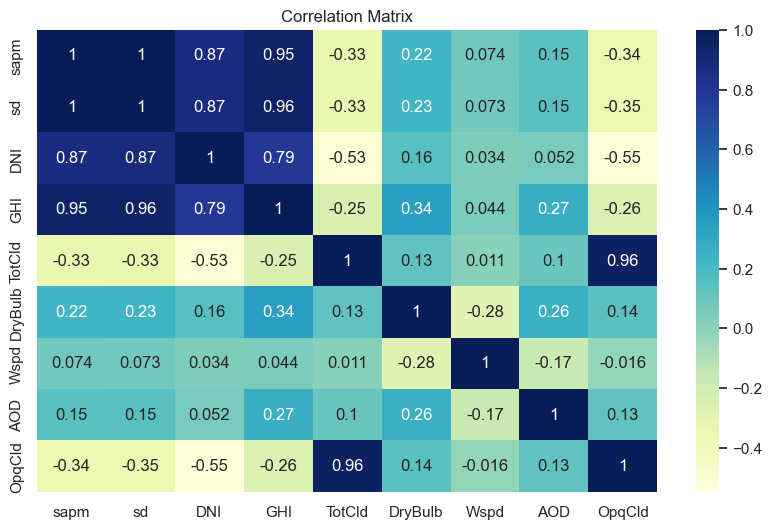

In [125]:
import seaborn as sns
sns.set(font_scale=1)
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.title('Correlation Matrix')
plt.show()